In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib inline

# СБОР И ОБРАБОТКА ДАННЫХ

### ЦЕЛЕВАЯ ПЕРЕМЕННАЯ ИССЛЕДОВАНИЯ - 'LIKES'

#### 1. Собираем данные из нескольких файлов (один файл csv на каждую страну) в один датасет

In [4]:
col_list = ['video_id', 'trending_date', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count']

In [5]:
total_info = {}
for file in os.listdir('C:/Users/99387/Downloads/kg/'):
    if '.csv' in file:
        try:
            total_info[file[:-4]] = pd.read_csv(f'C:/Users/99387/Downloads/kg/{file}', usecols=col_list)
        except Exception:
            continue
        print(file)

CAvideos.csv
DEvideos.csv
FRvideos.csv
GBvideos.csv
INvideos.csv
JPvideos.csv
KRvideos.csv
USvideos.csv


In [7]:
for country in total_info:
    total_info[country].insert(column = 'country', value = country, loc = 0)

In [8]:
countries = list(total_info.keys())
df = pd.DataFrame(columns= col_list)
for country in countries:
    df = df.append(total_info[country], ignore_index = True)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
numeric_columns = ['views',  'likes',  'dislikes',  'comment_count']

In [11]:
#изменим формат численных колонок
for column in numeric_columns:
    df[column] = df[column].astype('int32')
df['publish_time'] = df['publish_time'].astype('datetime64')

In [12]:
core_columns = numeric_columns.copy()
core_columns.append('country')

#### 2. Добавим названия категорий из отдельного файла

In [13]:
categories_json = pd.read_json(f'C:/Users/99387/Downloads/kg/CA_category_id.json')

In [14]:
categories = pd.DataFrame(columns = ['cat_id','category'])
for item in categories_json['items']:
    categories = categories.append({'cat_id': int(item['id']), 
                                    'category': item['snippet']['title']}, ignore_index=True)

In [15]:
df = df.merge(categories, left_on='category_id', right_on='cat_id').drop(['category_id'], axis = 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281301 entries, 0 to 281300
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   video_id       281301 non-null  object        
 1   trending_date  281301 non-null  object        
 2   publish_time   281301 non-null  datetime64[ns]
 3   tags           281301 non-null  object        
 4   views          281301 non-null  int32         
 5   likes          281301 non-null  int32         
 6   dislikes       281301 non-null  int32         
 7   comment_count  281301 non-null  int32         
 8   country        281301 non-null  object        
 9   cat_id         281301 non-null  object        
 10  category       281301 non-null  object        
dtypes: datetime64[ns](1), int32(4), object(6)
memory usage: 21.5+ MB


# EDA

### ОСНОВНЫЕ ПОКАЗАТЕЛИ

In [89]:
mean_likes = pd.DataFrame({df.loc[df['country']==country, 'likes'].mean() for country in countries}, columns = ['mean_likes'], index = countries)
mean_views = pd.DataFrame({df.loc[df['country']==country, 'views'].mean() for country in countries}, columns = ['mean_views'], index = countries)
std_likes = pd.DataFrame({df.loc[df['country']==country, 'likes'].std(ddof=1) for country in countries}, columns = ['std_likes'], index = countries)
std_views = pd.DataFrame({df.loc[df['country']==country, 'views'].std(ddof=1) for country in countries}, columns = ['std_views'], index = countries)
mean_likes = mean_likes.sort_values(by=['mean_likes'])
mean_views = mean_views.sort_values(by=['mean_views'])

<AxesSubplot:title={'center':'views: mean & std'}>

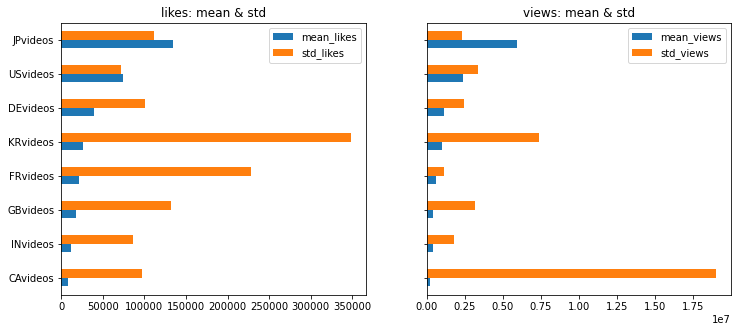

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2,  sharey=True, figsize = [12, 5])
mean_likes.join(std_likes).plot(kind ='barh', title = 'likes: mean & std', ax = axes[0])
mean_views.join(std_views).plot(kind ='barh', title = 'views: mean & std', ax = axes[1])

#### Вывод
среднеквадратичное отклонение заметно выше среднего значения, говорит о большом разбросе крайних значений. Наиболее сбалансированная ситуация в Японии и США.

### ПЕРВЫЙ ВЗГЛЯД, СРАЗУ СМОТРИМ С АКЦЕНТОМ НА ЗАВИСИМОСТИ ОТ СТРАНЫ

#### 1. Смотрим обычные scatter plots с подсветкой по стране, чтобы выявить линейные зависимости между переменными

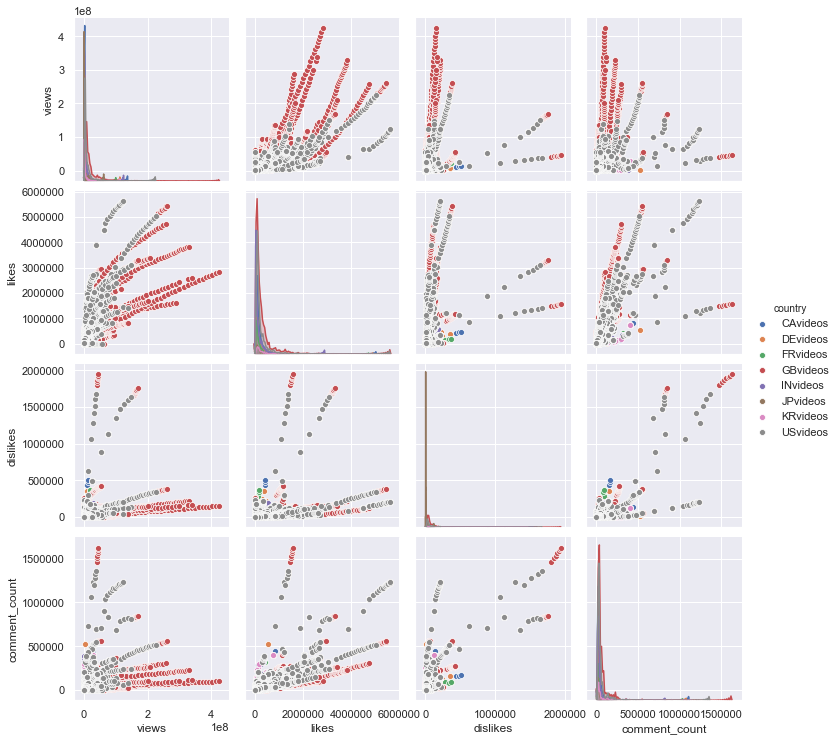

In [193]:
sns.set()
sns.pairplot(df[core_columns], hue = 'country')

#### Вывод 
линейная зависимость носит не самый выраженный харакрер. Разветвленность не объясняется принадлежностью к странам

1.1 Посмотрим на те же графики, без выбросов. Есть ли разница?

In [194]:
from scipy import stats
df_no_extra = df.loc[(np.abs(stats.zscore(df[['views',  'likes',  'dislikes',  'comment_count']])) < 3).all(axis=1)]

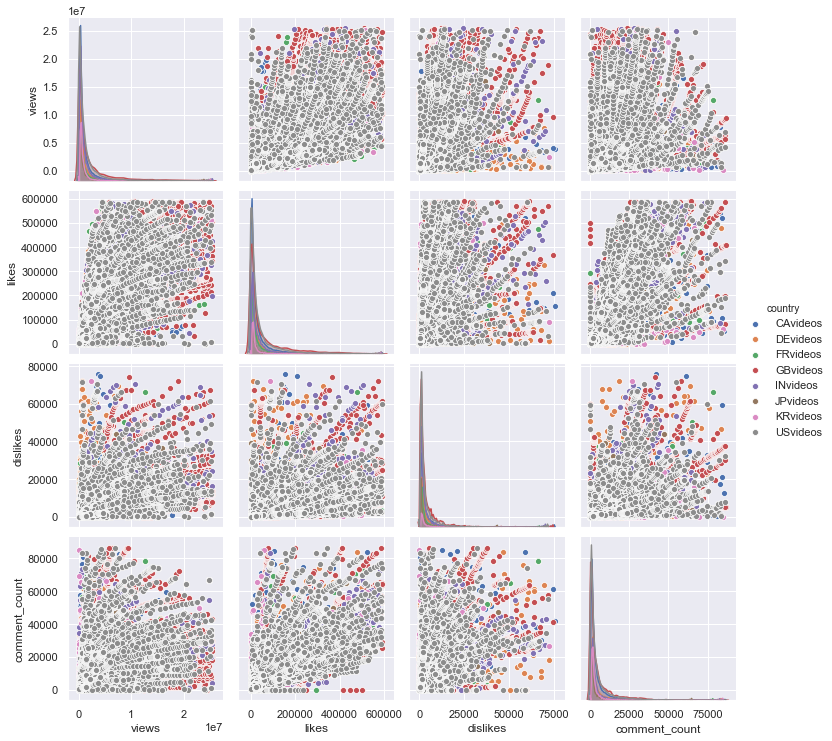

In [195]:
sns.set()
sns.pairplot(df_no_extra[core_columns], hue = 'country')

#### вывод 
очень слабая линейная зависимость вне зависимости от выбросов

#### 2. Смотрим корреляционные матрицы по странам

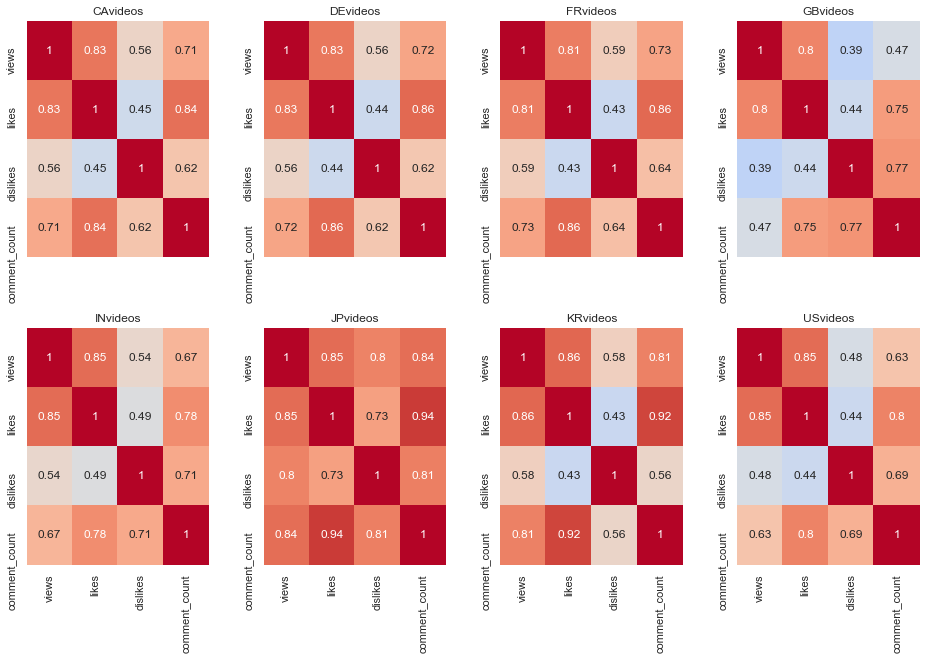

In [196]:
fig, axes = plt.subplots(nrows=2, ncols=4,  sharex=True, figsize = [16, 10])
axes = axes.flatten()
for i, country in enumerate(countries):
    sns.heatmap(df.loc[df['country']==country, core_columns].corr().abs(), 
            cmap='coolwarm', annot = True, ax = axes[i], cbar=False, vmin=0, vmax=1, center= 0.5)
    axes[i].set_title(country)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#### вывод 
неплохая корреляция кроме лайков/дизлайков. Довольо сильные отличия по станам

#### 3. Смотрим отдельно зависимости просмотров и лайков

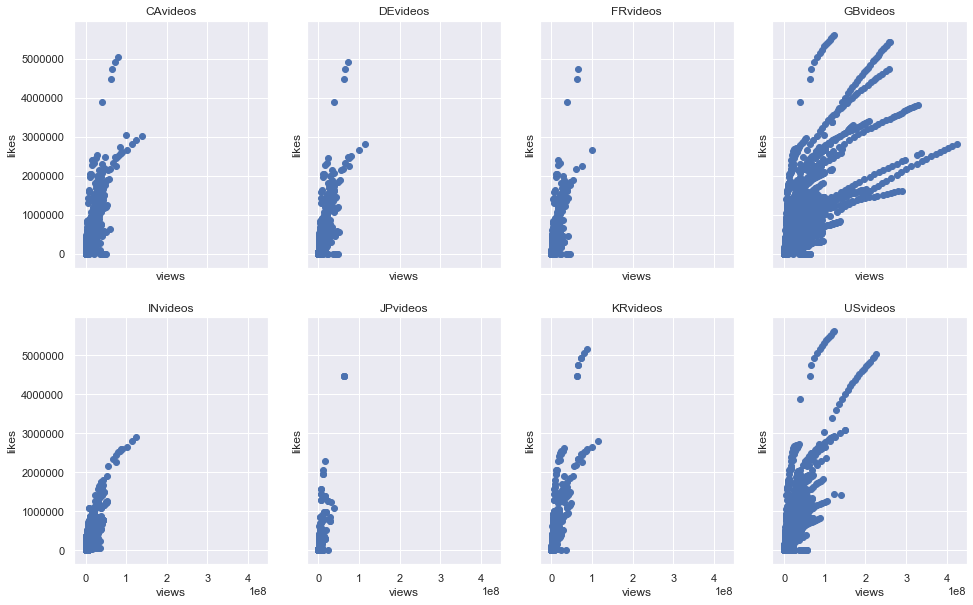

In [197]:
fig, axes = plt.subplots(nrows=2, ncols=4,  sharex=True, sharey=True, figsize = [16, 10])
axes = axes.flatten()
for i, country in enumerate(countries):
    axes[i].scatter(df.loc[df['country']==country, 'views'], df.loc[df['country']==country, 'likes'])
    axes[i].set_title(country)
    axes[i].set_xlabel('views')
    axes[i].set_ylabel('likes')

#### вывод
похоже на линейную зависимость с большим углом

#### 4. Проверим просмотры и лайки на нормальность распределения

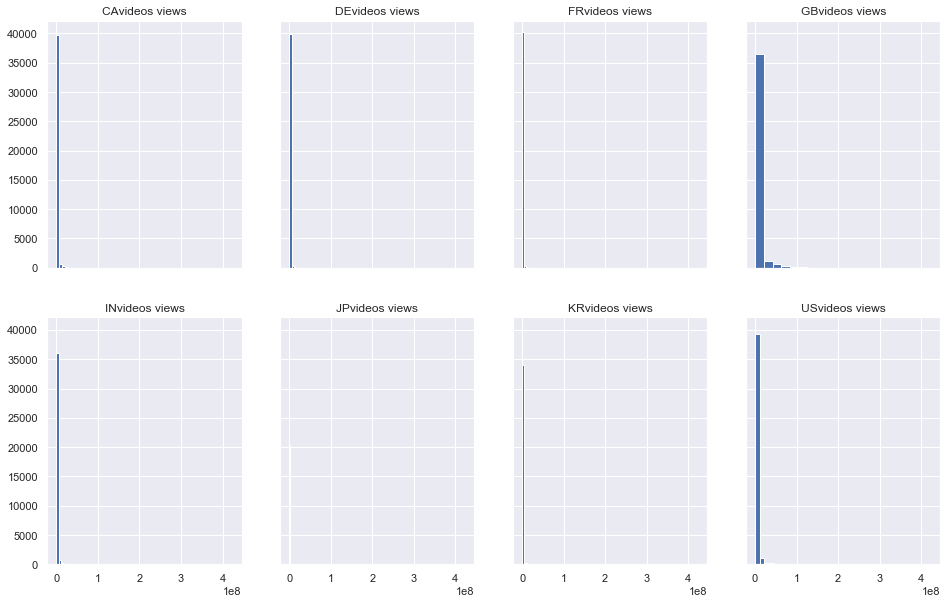

In [198]:
fig, axes = plt.subplots(nrows=2, ncols=4,  sharex=True, sharey=True, figsize = [16, 10])
axes = axes.flatten()
for i, country in enumerate(countries):
    axes[i].hist(df.loc[df['country']==country, 'views'], bins = 20)
    axes[i].set_title(f'{country} views')

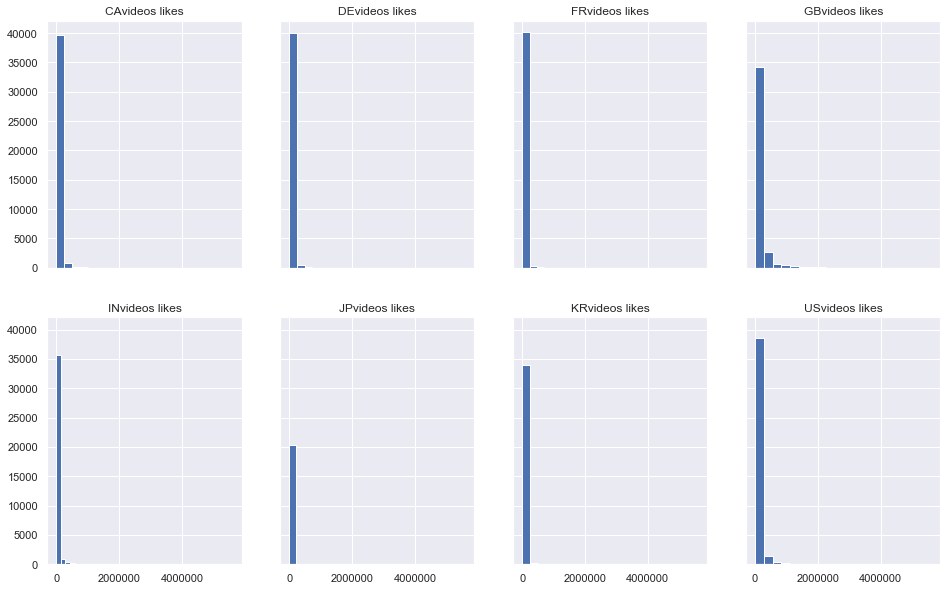

In [199]:
fig, axes = plt.subplots(nrows=2, ncols=4,  sharex=True, sharey=True, figsize = [16, 10])
axes = axes.flatten()
for i, country in enumerate(countries):
    axes[i].hist(df.loc[df['country']==country, 'likes'], bins = 20)
    axes[i].set_title(f'{country} likes')

#### вывод 
распределение нельзя назвать нормальным, явное смещение влево

#### 5. Посмотрим, отличается ли распределение просмотров и лайков по странам, сразу возьмем датасет без выбросов

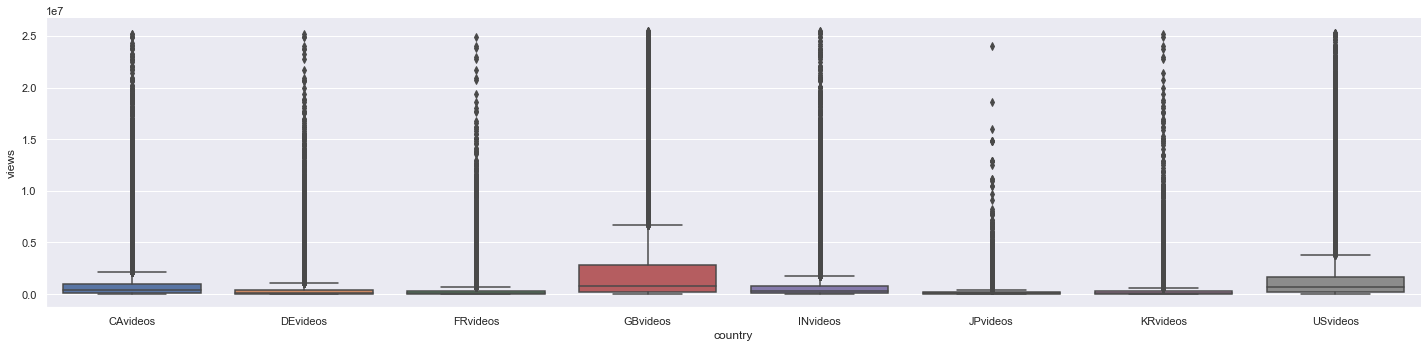

In [200]:
sns.catplot('country', 'views', kind="box", data=df_no_extra, aspect=4/1);

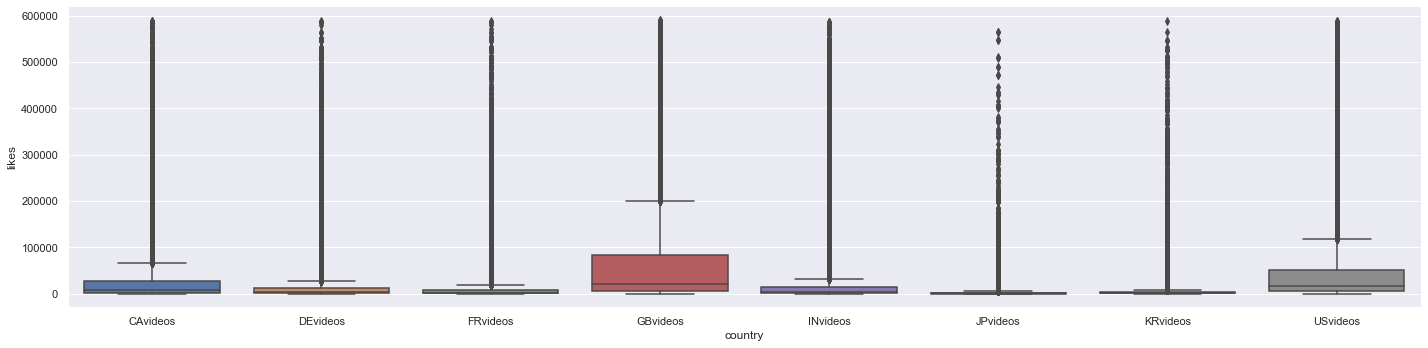

In [201]:
sns.catplot('country', 'likes', kind="box", data=df_no_extra, aspect=4/1);

#### вывод
Отличия вполне заметны. 
#### 6 Проверим статистическую значимость этих различий с помощью регрессионного анализа на всем датасете

In [202]:
#списки просмотров по странам
views = get_values_by_ctg(df, 'country', 'views')

In [203]:
stats.f_oneway(*views)

F_onewayResult(statistic=2242.3802317584714, pvalue=0.0)

In [204]:
#списки лайков по странам
likes = get_values_by_ctg(df, 'country', 'likes')

In [205]:
stats.f_oneway(*likes)

F_onewayResult(statistic=2154.10288436326, pvalue=0.0)

#### Вывод 
p значение крайне мало, а значит, мы можем сделать итак очевидный вывод вывод о статистически значимом влиянии страны на кол-во лайков и просмотров в абсолютном выражении на уровне значимости 0.5 и даже 0.1.

# ДОПОЛНИТЕЛЬНЫЕ ИССЛЕДОВАНИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

### ЗАВИСИМОСТИ ОТ ДНЯ НЕДЕЛИ ПУБЛИКАЦИИ

In [206]:
df.insert(3, 'weekday', df['publish_time'].dt.dayofweek.astype('str'))

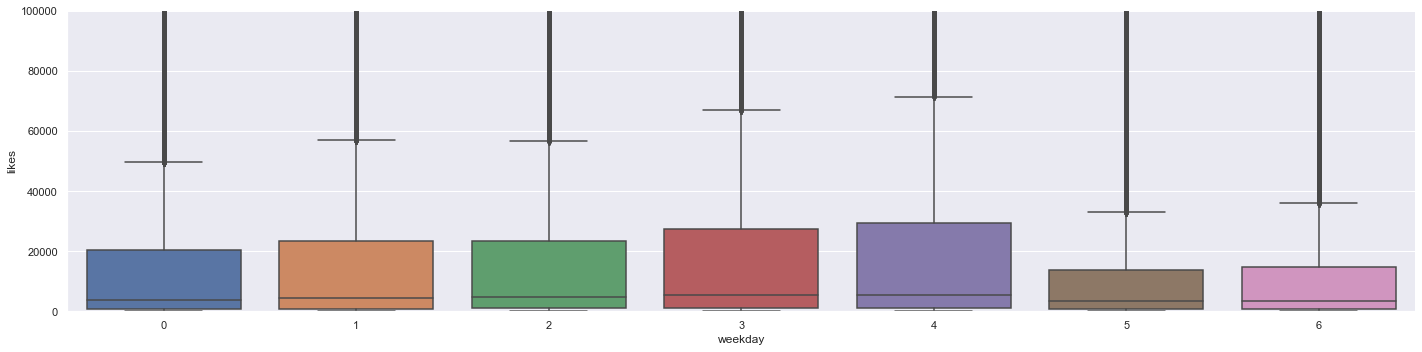

In [207]:
#сразу строим c лимитом по количеству лайков, иначе, из за больших разбросов в верхнем квартиле, график не смотрибельный
sns.catplot('weekday', 'likes', kind="box", data=df, aspect=4/1).set(ylim=(0, 100000))

In [208]:
#списки лайков по дням недели
likes_wd = get_values_by_ctg(df, 'weekday', 'likes')

In [209]:
stats.f_oneway(*likes_wd)

F_onewayResult(statistic=205.46032182299757, pvalue=1.39876298668708e-262)

#### Вывод
можем принять также вывод о статистической значимости влияния дня недели на распределение лайков.

### ЗАВИСИМОСТИ ОТ КАТЕГОРИИ

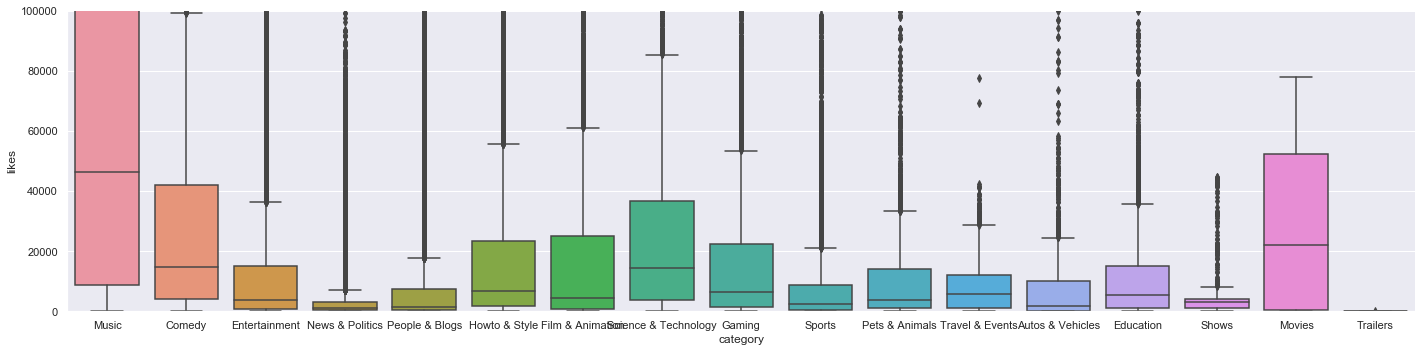

In [210]:
sns.catplot('category', 'likes', kind="box", data=df, aspect=4/1).set(ylim=(0, 100000))

In [211]:
#списки лайков по категориям
likes_ctg = get_values_by_ctg(df, 'category', 'likes')

In [212]:
stats.f_oneway(*likes_ctg)

F_onewayResult(statistic=1802.1653398986964, pvalue=0.0)

#### Вывод
можем принять также вывод о статистической значимости влияния категории на распределение лайков.

# ПОСТРОЕНИЕ МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ

#### добавим количество дней с момента публикации

In [213]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['days_before_intrend'] = (df['trending_date']-df['publish_time']).dt.days

#### переведем категориальные признаки в dummy переменные

In [214]:
def make_dummy(df, feature):
    for i in df[feature].unique():
        df[feature + '=' + i] = (df[feature] == i).astype('int32')
make_dummy(df, 'category')
make_dummy(df, 'country')
make_dummy(df, 'weekday')

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293750 entries, 0 to 293749
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   video_id                       293750 non-null  object        
 1   trending_date                  293750 non-null  datetime64[ns]
 2   publish_time                   293750 non-null  datetime64[ns]
 3   weekday                        293750 non-null  object        
 4   tags                           293750 non-null  object        
 5   views                          293750 non-null  int32         
 6   likes                          293750 non-null  int32         
 7   dislikes                       293750 non-null  int32         
 8   comment_count                  293750 non-null  int32         
 9   country                        293750 non-null  object        
 10  cat_id                         293750 non-null  object        
 11  

In [216]:
model = LinearRegression()

In [217]:
X = df.select_dtypes(include = ['int32','int64']).drop('likes', axis = 1)
y = df['likes']

In [218]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [219]:
model.coef_, model.intercept_

(array([ 1.16629854e-02, -2.02851637e+00,  4.70297957e+00, -8.55012764e+00,
         4.33584072e+04,  1.19634904e+04, -8.40893377e+02, -5.73432549e+03,
        -1.31586765e+03, -2.95933190e+03, -2.82374742e+03, -1.26481788e+04,
        -1.92394306e+03, -2.53926119e+03, -3.15717251e+03, -7.18827440e+03,
        -5.53142386e+03,  3.97185222e+02, -4.72013154e+03, -3.02494542e+03,
        -1.31158632e+03,  8.59247542e+02,  3.53062388e+02, -6.80469295e+02,
         2.56458293e+03, -1.01583933e+03, -3.88095131e+03, -4.59671616e+03,
         6.39708323e+03,  5.65898101e+02,  2.34601980e+03, -8.89328267e+02,
         1.20047851e+03, -1.90334091e+03, -1.98153524e+03,  6.61808013e+02]),
 2694.2878974242194)

In [220]:
predictions = model.predict(X)

In [221]:
model.score(X, y)

0.8657904153846968